# Rare Variants

In [1]:
import copy
import cPickle
import datetime as dt
import glob
import os
import re
import subprocess
import urllib2

import cdpybio as cpb
from ipyparallel import Client
from scipy.stats import fisher_exact
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyencodetools as pet
import pybedtools as pbt
import scipy
import scipy.stats as stats
import seaborn as sns
import socket
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'rare_variant_processing'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [3]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
genes = pbt.BedTool(cpy.gencode_gene_bed)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)

cnvs = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data',
                                  'cnvs.tsv'), index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
rna_meta_eqtl = rna_meta[rna_meta.in_eqtl]
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

rna_meta = rna_meta.merge(subject_meta, left_on='subject_id', right_index=True)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

In [6]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

In [7]:
log_tpm = np.log10(tpm + 1)

## SNVs and indels

Get SNVs and indels in promoters.

In [8]:
promoter_bt = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_merged.bed')
df = promoter_bt.to_dataframe()
s = '\n'.join(df.chrom.apply(lambda x: x[3:]) + '\t' + 
              df.start.astype(str) + '\t' + df.end.astype(str)) + '\n'
promoter_bt = pbt.BedTool(s, from_string=True)

In [9]:
vcfs = ['CARDIPS_chr{}_phased.vcf.gz'.format(x) for x in range(1, 23)]
vcfs = [os.path.join('/projects/CARDIPS/pipeline/WGS/mergedVCF/phased_20151214/', x) for x in vcfs]
for vcf in vcfs:
    out = os.path.split(vcf)[1].split('.')[0] + '_promoter_variants.vcf.gz'
    out = os.path.join(private_outdir, out)
    if not os.path.exists(out):
        c = 'bcftools view -Oz -R {} {} > {}'.format(promoter_bt.fn, vcf, out)
        subprocess.check_call(c, shell=True)
        c = 'bcftools index {}'.format(out)
        subprocess.check_call(c, shell=True)

Annotate variants with 1,000 genomes European allele frequency.

In [10]:
for i in range(1, 23):
    vcf = os.path.join(private_outdir, 'CARDIPS_chr{}_phased_promoter_variants.vcf.gz'.format(i))
    kgp_vcf = ('/publicdata/1KGP_20151103/ALL.chr{}.'
               'phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz'.format(i))
    out = os.path.split(vcf)[1].split('.')[0] + '_annot.vcf.gz'
    out = os.path.join(private_outdir, out)
    if not os.path.exists(out):
        c = ('bcftools annotate -a {} -c EUR_AF -Oz {} > {}'.format(kgp_vcf, vcf, out))
        subprocess.check_call(c, shell=True)
        c = 'bcftools index {}'.format(out)
        subprocess.check_call(c, shell=True)

Make merged bed file for roadmap DHSs for stem cell.

In [11]:
out = os.path.join(outdir, 'roadmap_stem_cell_dhs.bed')
if not os.path.exists(out):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(E\d\d\d-DNase.macs2.narrowPeak.gz)"', html)
    roadmap_dnase_res = pd.DataFrame(
        -1, index=[x.split('-')[0] for x in files], 
        columns=['odds_ratio', 'pvalue'])

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = ['iPS-15b Cell Line', 'iPS-18 Cell Line', 'iPS-20b Cell Line',
             'iPS DF 6.9 Cell Line', 'iPS DF 19.11 Cell Line', 'H1 Cell Line',
             'H9 Cell Line']
    urls = [x for x in urls if roadmap_ids[os.path.split(x.split('-')[0])[1]] in lines]

    dhs_bt = pbt.BedTool(''.join([cpb.general.read_gzipped_text_url(url) for url in urls]), from_string=True)
    dhs_bt = dhs_bt.sort().merge()
    df = dhs_bt.to_dataframe()
    df.chrom = df.chrom.apply(lambda x: x[3:])
    s = '\n'.join(df.chrom + '\t' + df.start.astype(str) + 
                  '\t' + df.end.astype(str)) + '\n'
    dhs_bt = pbt.BedTool(s, from_string=True)
    dhs_bt.saveas(out)
else:
    dhs_bt = pbt.BedTool(out)

Get variants that overlap merged DHSs.

In [12]:
vcfs = [os.path.join(private_outdir, 'CARDIPS_chr{}_phased_promoter_variants_annot.vcf.gz'.format(x)) 
        for x in range(1, 23)]
for vcf in vcfs:
    out = os.path.split(vcf)[1].split('.')[0] + '_dhs.vcf.gz'
    out = os.path.join(private_outdir, out)
    if not os.path.exists(out):
        temp = os.path.join(private_outdir, 'temp.vcf')
        c = 'bcftools view -m2 -M2 -Ov -R {} {} > {}'.format(dhs_bt.fn, vcf, temp)
        subprocess.check_call(c, shell=True)
        temp_header = os.path.join(private_outdir, 'temp_header.vcf')
        c = 'grep ^\\# {} > {}'.format(temp, temp_header)
        subprocess.check_call(c, shell=True)
        temp_lines = os.path.join(private_outdir, 'temp_lines.vcf')
        c = 'grep -v ^\\# {} | sort -k1,1 -k2,2n | uniq > {}'.format(temp, temp_lines)
        subprocess.check_call(c, shell=True)
        c = 'cat {} {} | bgzip > {}'.format(temp_header, temp_lines, out)
        subprocess.check_call(c, shell=True)
        c = 'bcftools index {}'.format(out)
        subprocess.check_call(c, shell=True)
        c = 'rm {} {} {}'.format(temp, temp_header, temp_lines)
        subprocess.check_call(c, shell=True)

Filter promoter variants to only keep rare variants.

In [14]:
unrelateds = list(rna_meta_eqtl.ix[rna_meta_eqtl.in_unrelateds, 'wgs_id'])

In [ ]:
vcfs = [os.path.join(private_outdir, 'CARDIPS_chr{}_phased_promoter_variants_annot_dhs.vcf.gz'.format(x)) 
        for x in range(1, 23)]

ind = []
rare_vars = []
rare_var_genotypes = []
for vcf in vcfs:
    vcf_reader = pyvcf.Reader(open(vcf))
    out = vcf.split('.')[0] + '_rare.vcf.gz'
    if not os.path.exists(out):
        f = open(out[:-3], 'w')
        vcf_writer = pyvcf.Writer(f, vcf_reader)
        eur_af = []
        unr_af = []
        unr_num_called = []
        for r in vcf_reader:
            if 'EUR_AF' in r.INFO.keys():
                eaf = r.INFO['EUR_AF'][0]
            else:
                eaf = 0
            eaf

            s = [x.sample for x in r.samples if x.called]
            gt = [x.gt_alleles for x in r.samples if x.called]
            gt = pd.DataFrame(gt, index=s, columns=['allele_a', 'allele_b'])
            gt = gt.ix[unrelateds].dropna()
            unr_num_called = gt.shape[0]

            se = pd.Series(0, index=['0', '1'])
            vc = gt.allele_a.value_counts()
            se.ix[vc.index] += vc
            vc = gt.allele_b.value_counts()
            se.ix[vc.index] += vc
            #uaf = float(se.min()) / se.sum()
            uac = se.min()
            if eaf < 0.005 and uac == 1 and unr_num_called >= 100:
                vcf_writer.write_record(r)
                pos = 'chr{}:{}-{}'.format(r.CHROM, r.POS - 1, r.POS - 1 + len(r.REF))
                ind.append(pos)
                rare_vars.append(['chr{}'.format(r.CHROM), r.POS - 1, r.POS - 1 + len(r.REF), 
                                  r.ID, pos, r.REF, str(r.ALT[0]), eaf])
                se = pd.concat([pd.Series(0, index=[x.sample for x in r.get_hom_refs()]),
                                pd.Series(1, index=[x.sample for x in r.get_hets()]),
                                pd.Series(0, index=[x.sample for x in r.get_hom_alts()])])
                rare_var_genotypes.append(se)
                
        vcf_writer.close()
        f.close()
        !bgzip {out[:-3]}
        !bcftools index {out}

In [ ]:
2 + 2

In [71]:
t = pd.DataFrame(rare_var_genotypes)

In [68]:
t.isnull().sum(axis=1).value_counts()

0    2620
1       3
9       1
3       1
8       1
6       1
4       1
dtype: int64

In [54]:
rare_vars[1]

['chr22', 17306446, 'rs112616530', 'C', T, 0.001]

In [51]:
se.shape

(2,)

In [49]:
se.shape

(292,)

In [ ]:
                s = set([x.sample for x in r.get_hom_refs()]) & gcols
                if len(s) > 0:
                    genotypes.ix[key, s] = 0
                s = set([x.sample for x in r.get_hets()]) & gcols
                if len(s) > 0:
                    genotypes.ix[key, s] = 1
                s = set([x.sample for x in r.get_hom_alts()]) & gcols
                if len(s) > 0:
                    genotypes.ix[key, s] = 2

In [16]:
out = os.path.join(private_outdir, 'all_rare_variants.tsv')
if not os.path.exists(out):
    all_rare_vars = []
    vcfs = [os.path.join(private_outdir, 'CARDIPS_chr{}_phased_promoter_variants_annot_dhs_rare.vcf.gz'.format(x)) 
            for x in range(1, 23)]
    for vcf in vcfs:
        temp = os.path.join(private_outdir, 'temp.vcf')
        !gunzip -c {vcf} > {temp}
        vcf_bt = pbt.BedTool(temp)
        t = vcf_bt.to_dataframe(names=range(len(vcf_bt[0].fields)))
        t = t[t[0].apply(lambda x: str(x)[0] != '#')][range(5)]
        t.columns = ['chrom', 'position', 'vid', 'ref', 'alt']
        t.chrom = 'chr' + t.chrom.astype(str)
        t.index = t.chrom + ':' + t.position.astype(str)
        all_rare_vars.append(t)
        !rm {temp}
    all_rare_vars = pd.concat(all_rare_vars)
    all_rare_vars['position'] = all_rare_vars['position'].astype(int)
    all_rare_vars['location'] = (all_rare_vars.chrom + ':' + (all_rare_vars.position - 1).astype(str) + '-' + 
                                 (all_rare_vars.position - 1 + all_rare_vars.ref.apply(lambda x: len(x))).astype(str))
    all_rare_vars.to_csv(out, sep='\t')
else:
    all_rare_vars = pd.read_table(out, index_col=0)

In [17]:
promoters = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_by_gene.bed')
df = promoters.to_dataframe()
s = '\n'.join(df.chrom.apply(lambda x: x[3:]) + '\t' + 
              df.start.astype(str) + '\t' + df.end.astype(str) + 
              '\t' + df.name) + '\n'
promoters = pbt.BedTool(s, from_string=True)

In [18]:
outa = os.path.join(private_outdir, 'rare_promoter_vars.tsv')
outb = os.path.join(private_outdir, 'rare_genotypes.tsv')
if not os.path.exists(outa) or not os.path.exists(outb):
    rare_promoter_vars = []
    rare_genotypes = []
    vcfs = [os.path.join(private_outdir, 'CARDIPS_chr{}_phased_promoter_variants_annot_dhs_rare.vcf.gz'.format(x)) 
            for x in range(1, 23)]
    for vcf in vcfs:
        temp = os.path.join(private_outdir, 'temp.vcf')
        !gunzip -c {vcf} > {temp}
        vcf_bt = pbt.BedTool(temp)

        res = vcf_bt.intersect(promoters, sorted=True, wo=True)
        df = res.to_dataframe(names=range(len(res[0].fields)))

        se = df[304].apply(lambda x: x.split('_')[0])
        se.index = df[0].astype(str) + ':' + df[1].astype(str)
        rare_promoter_vars.append(se)

        genotypes = pd.DataFrame(np.nan, index=set(se.index), columns=list(set(rna_meta.wgs_id)))
        gcols = set(genotypes.columns)
        vcf_reader = pyvcf.Reader(open(vcf))

        for r in vcf_reader:
            key = r.CHROM + ':' + str(r.POS)
            if key in genotypes.index:
                s = set([x.sample for x in r.get_hom_refs()]) & gcols
                if len(s) > 0:
                    genotypes.ix[key, s] = 0
                s = set([x.sample for x in r.get_hets()]) & gcols
                if len(s) > 0:
                    genotypes.ix[key, s] = 1
                s = set([x.sample for x in r.get_hom_alts()]) & gcols
                if len(s) > 0:
                    genotypes.ix[key, s] = 2
        rare_genotypes.append(genotypes)
        !rm {temp}
    rare_genotypes = pd.concat(rare_genotypes)
    rare_promoter_vars = pd.concat(rare_promoter_vars)
    rare_promoter_vars.to_csv(outa, sep='\t')
    rare_genotypes.to_csv(outb, sep='\t')
else:
    rare_promoter_vars = pd.read_table(outa, index_col=0, header=None, squeeze=True)
    rare_genotypes = pd.read_table(outb, index_col=0)

In [18]:
rare_genotypes_f = rare_genotypes[rare_genotypes[unrelateds].sum(axis=1) > 0]
rare_genotypes_f = rare_genotypes_f[unrelateds]

In [19]:
rare_genotypes_f = rare_genotypes_f[rare_genotypes_f.sum(axis=1) == 1]

In [20]:
log_tpm_f = log_tpm[rna_meta[rna_meta.in_unrelateds].index]
log_tpm_f.columns = rna_meta.ix[rna_meta.in_unrelateds, 'wgs_id']
log_tpm_f = log_tpm_f[(log_tpm_f > np.log10(2)).sum(axis=1) >= 10]

In [21]:
log_tpm_c = (log_tpm_f.T - log_tpm_f.mean(axis=1)).T
log_tpm_z = (log_tpm_c.T / log_tpm_c.std(axis=1)).T

In [22]:
rare_promoter_vars_f = rare_promoter_vars[rare_promoter_vars.apply(lambda x: x in log_tpm_f.index)]
rare_promoter_vars_f = pd.DataFrame({'variant':rare_promoter_vars_f.index, 'gene':rare_promoter_vars_f.values})
rare_promoter_vars_f = rare_promoter_vars_f[rare_promoter_vars_f.variant.apply(lambda x: x in rare_genotypes_f.index)]

In [23]:
ase_pval_f = ase_pval[rna_meta[rna_meta.in_unrelateds].index]
ase_pval_f.columns = rna_meta[rna_meta.in_unrelateds].wgs_id

In [56]:
all_rare_vars.head()

,chrom,position,vid,ref,alt,location
chr1:10523,chr1,10523,.,TCCG,T,chr1:10522-10526
chr1:566948,chr1,566948,.,CACA,C,chr1:566947-566951
chr1:567239,chr1,567239,rs78150957,CG,C,chr1:567238-567240
chr1:713977,chr1,713977,rs74512038,C,T,chr1:713976-713977
chr1:714024,chr1,714024,.,C,A,chr1:714023-714024


In [24]:
rare = []
rare_ase_pval = []
not_rare = []
not_rare_ase_pval = []
for i in rare_promoter_vars_f.index:
    v = rare_promoter_vars_f.ix[i, 'variant']
    g = rare_promoter_vars_f.ix[i, 'gene']
    se = rare_genotypes_f.ix[v]
    r = se[se != 0].index
    nr = se[se == 0].index
    rare += list(log_tpm_z.ix[g, r])
    not_rare += list(log_tpm_z.ix[g, nr])
    if g in ase_pval.index:
        rare_ase_pval += list(ase_pval_f.ix[g, r])
        not_rare_ase_pval += list(ase_pval_f.ix[g, nr])
rare = pd.Series(rare)
not_rare = pd.Series(not_rare)
rare_ase_pval = pd.Series(rare_ase_pval).dropna()
not_rare_ase_pval = pd.Series(not_rare_ase_pval).dropna()

In [25]:
r = sum(rare_ase_pval < 0.005) / float(rare_ase_pval.shape[0])
nr = sum(not_rare_ase_pval < 0.005) / float(not_rare_ase_pval.shape[0])
a = (rare_ase_pval < 0.005).value_counts()
b = (not_rare_ase_pval < 0.005).value_counts()
odds, p = stats.fisher_exact([[a[True], a[False]], [b[True], b[False]]])
print('Gene/samples with rare promoter DHS variant have ASE {:.2f}% of the '
      'time while gene/samples without rare promoter DHS variant have ASE '
      '{:.2f}% of the time (odds={:.2f}, p={:.2e}, Fisher exact).'.format(r * 100, nr * 100, odds, p))

Gene/samples with rare promoter DHS variant have ASE 3.32% of the time while gene/samples without rare promoter DHS variant have ASE 2.85% of the time (odds=1.17, p=7.25e-07, Fisher exact).


Gene/sample pairs with a rare DHS promoter variant are enriched for ASE.

In [26]:
s,p = stats.mannwhitneyu(rare, not_rare)
print('The distributions of z-score expression values for genes with and without '
      'rare promoter DHS variants is significantly different (Mann-Whitney U, p={:.2e}).'.format(p))

The distributions of z-score expression values for genes with and without rare promoter DHS variants is significantly different (Mann-Whitney U, p=1.61e-103).


In [27]:
s,p = stats.mannwhitneyu(rare.abs(), not_rare.abs())
print('The distributions of z-score expression magnitudes for genes with and without '
      'rare promoter DHS variants is significantly different (Mann-Whitney U, p={:.2e}).'.format(p))

The distributions of z-score expression magnitudes for genes with and without rare promoter DHS variants is significantly different (Mann-Whitney U, p=1.18e-64).


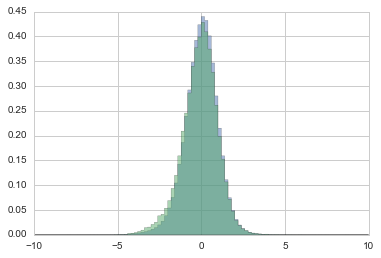

In [28]:
not_rare.hist(normed=True, bins=np.arange(-10, 10.2, 0.2), alpha=0.5, histtype='stepfilled')
rare.hist(normed=True, bins=np.arange(-10, 10.2, 0.2), alpha=0.5, histtype='stepfilled')

In [31]:
xs = np.arange(-10, 10.1, 0.1)
density = scipy.stats.gaussian_kde(rare)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)

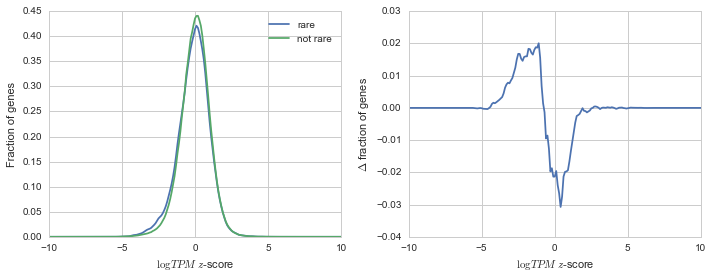

In [32]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]

y_rare.plot(label='rare', ax=ax)
y_not_rare.plot(label='not rare', ax=ax)
ax.legend()
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score')
ax = axs[1]
(y_rare - y_not_rare).plot(ax=ax)
ax.set_ylabel('$\Delta$ fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'rare_var_effect.pdf'))

In [33]:
not_rare.mean() - rare.mean()

0.0955357974836233

In [34]:
not_rare.median() - rare.median()

0.06242488525957347

TODO: Estimate effect size, or estimate FDR (for instance, at z=-3, rare variants are functional
with FDR 20%).

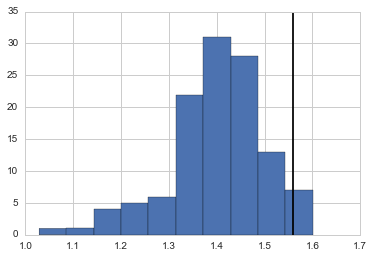

In [35]:
v = rare_genotypes_f.index[0]
g = rare_promoter_vars[v]
if type(g) == pd.Series:
    g = g.values[0]
if g in log_tpm_f.index:
    se = rare_genotypes_f.ix[v]
    log_tpm_f.ix[g].hist()
    ymin,ymax = plt.ylim()
    plt.vlines(log_tpm_f.ix[g, se[se != 0].index], ymin, ymax)

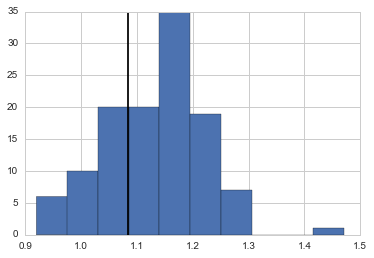

In [36]:
v = rare_genotypes_f.index[2]
g = rare_promoter_vars[v]
if type(g) == pd.Series:
    g = g.values[0]
if g in log_tpm_f.index:
    se = rare_genotypes_f.ix[v]
    log_tpm_f.ix[g].hist()
    ymin,ymax = plt.ylim()
    plt.vlines(log_tpm_f.ix[g, se[se != 0].index], ymin, ymax)

### TF motif disruptions

We can see that promoter variants in DHS disrupt expression. Is the signal stronger
if we also require the variants to disrupt TF motifs?

In [37]:
encode_tf_chip_seq = pd.read_table(os.path.join(ciepy.root, 'output', 
                                                'functional_annotation_analysis', 
                                                'encode_stem_cell_chip_seq.tsv'), index_col=0)
encode_tf_chip_seq = encode_tf_chip_seq.drop_duplicates(subset='target')
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
motif_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_rep.tsv')
motif_info_rep = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'matrices.pickle')
with open(fn) as f:
    matrices = cPickle.load(f)
encode_tf_chip_seq = encode_tf_chip_seq[encode_tf_chip_seq.target.apply(lambda x: x in set(motif_info_rep.tf))]

In [38]:
out = os.path.join(private_outdir, 'tf_overlap.tsv')
if not os.path.exists(out):
    s = '\n'.join(all_rare_vars.chrom + '\t' + (all_rare_vars.position - 1).astype(str) + 
                  '\t' + all_rare_vars.position.astype(str) + '\t' + 
                  pd.Series(all_rare_vars.index, index=all_rare_vars.index)) + '\n'
    rv_bt = pbt.BedTool(s, from_string=True).sort()
    tf_overlap = pd.DataFrame(False, index=all_rare_vars.index, columns=encode_tf_chip_seq.target)

    for i in encode_tf_chip_seq.index:
        target = encode_tf_chip_seq.ix[i, 'target']
        s = cpb.general.read_gzipped_text_url(encode_tf_chip_seq.ix[i, 'narrowPeak_url'])
        bt = pbt.BedTool(s, from_string=True)
        bt = bt.sort()
        res = rv_bt.intersect(bt, sorted=True, wo=True)
        df = res.to_dataframe(names=range(len(res[0].fields)))
        tf_overlap.ix[set(df[3]), target] = True
    tf_overlap.to_csv(out, sep='\t')
else:
    tf_overlap = pd.read_table(out, index_col=0)

In [39]:
out = os.path.join(outdir, 'tf_disruption.tsv')
if not os.path.exists(out):
    tdf = tf_overlap[tf_overlap.sum(axis=1) > 0]
    var_tf_overlaps = {}
    for i in tdf.index:
        se = tdf.ix[i]
        se = se[se]
        var_tf_overlaps[i] = list(motif_info[motif_info.tf.apply(lambda x: x in se.index)].index)
    tf_disruption = pd.DataFrame(False, index=tf_overlap.index, columns=tf_overlap.columns)

    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    with dview.sync_imports():
        import cdpybio
        import cardipspy
        
    %px cpb = cdpybio
    %px cpy = cardipspy
    
    dview.push(dict(all_rare_vars=all_rare_vars));
    dview.push(dict(var_tf_overlaps=var_tf_overlaps));
    dview.push(dict(matrices=matrices));
    
    res = dview.map_sync(lambda i: cpb.moodsext.find_motif_disruptions(
            all_rare_vars.ix[i, 'location'], all_rare_vars.ix[i, 'ref'], all_rare_vars.ix[i, 'alt'], 
            cpy.hg19, {k:matrices[k] for k in matrices.keys() if k in var_tf_overlaps[i]}), 
                         var_tf_overlaps.keys())
    for i,k in enumerate(var_tf_overlaps.keys()):
        if res[i].shape[0] > 0:
            tf_disruption.ix[k, set(motif_info.ix[res[i][res[i]['score_diff'].abs() >= 2.5].index, 'tf'])] = True
    tf_disruption.to_csv(out, sep='\t')
else:
    tf_disruption = pd.read_table(out, index_col=0)

In [40]:
t = pd.DataFrame({'variant':tf_disruption[tf_disruption.sum(axis=1) > 0].index,
                  'tf_disrupt':True})
t['variant'] = t.variant.apply(lambda x: x[3:])
rare_promoter_vars_f_tf = rare_promoter_vars_f.merge(t)

In [41]:
tf_rare = []
tf_rare_ase_pval = []
not_tf_rare = []
not_tf_rare_ase_pval = []
for i in rare_promoter_vars_f_tf.index:
    v = rare_promoter_vars_f_tf.ix[i, 'variant']
    g = rare_promoter_vars_f_tf.ix[i, 'gene']
    se = rare_genotypes_f.ix[v]
    r = se[se != 0].index
    nr = se[se == 0].index
    tf_rare += list(log_tpm_z.ix[g, r])
    not_tf_rare += list(log_tpm_z.ix[g, nr])
    if g in ase_pval.index:
        tf_rare_ase_pval += list(ase_pval_f.ix[g, r])
        not_tf_rare_ase_pval += list(ase_pval_f.ix[g, nr])
tf_rare = pd.Series(tf_rare)
not_tf_rare = pd.Series(not_tf_rare)
tf_rare_ase_pval = pd.Series(tf_rare_ase_pval).dropna()
not_tf_rare_ase_pval = pd.Series(not_tf_rare_ase_pval).dropna()

In [42]:
print(sum(tf_rare_ase_pval < 0.005) / float(tf_rare_ase_pval.shape[0]))
print(sum(not_tf_rare_ase_pval < 0.005) / float(not_tf_rare_ase_pval.shape[0]))

0.0342326003174
0.0282898456679


In [43]:
[[a[True], a[False]], [b[True], b[False]]]

[[1087, 31697], [91917, 3136622]]

In [44]:
a = (tf_rare_ase_pval < 0.005).value_counts()
b = (not_tf_rare_ase_pval < 0.005).value_counts()
stats.fisher_exact([[a[True], a[False]], [b[True], b[False]]])

(1.2175127308518565, 0.001118541626587175)

In [45]:
stats.mannwhitneyu(rare, tf_rare)

MannwhitneyuResult(statistic=745230261.0, pvalue=0.24648715857328146)

In [46]:
stats.mannwhitneyu(rare.abs(), tf_rare.abs())

MannwhitneyuResult(statistic=743983155.0, pvalue=0.14771315703930044)

In [47]:
stats.mannwhitneyu(tf_rare, not_tf_rare)

MannwhitneyuResult(statistic=20991202007.5, pvalue=1.0861693777795592e-26)

In [48]:
stats.mannwhitneyu(tf_rare.abs(), not_tf_rare.abs())

MannwhitneyuResult(statistic=20967195077.5, pvalue=6.1988492896309064e-28)

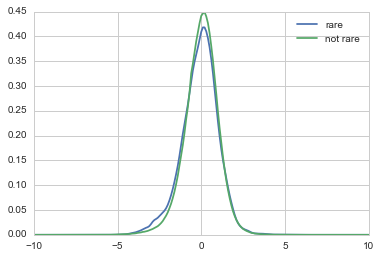

In [49]:
xs = np.arange(-10, 10.1, 0.1)
density = scipy.stats.gaussian_kde(tf_rare)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(not_tf_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()

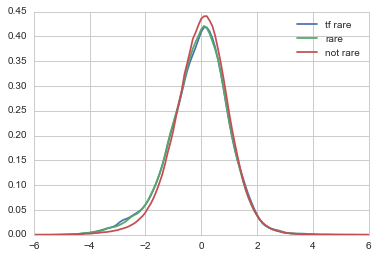

In [50]:
xs = np.arange(-6, 6.1, 0.1)
density = scipy.stats.gaussian_kde(tf_rare)
y_tf_rare = density(xs)
density = scipy.stats.gaussian_kde(rare)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(not_rare)
y_not_rare = density(xs)
y_tf_rare = pd.Series(y_tf_rare, index=xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_tf_rare.plot(label='tf rare')
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()

## Rare CNVs

In [ ]:
fn = os.path.join(ciepy.root, 'output/cnv_processing/cnv_info.tsv')
cnv_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'private_output/cnv_processing/cnv_genotypes.tsv')
cnv_geno = pd.read_table(fn, index_col=0)

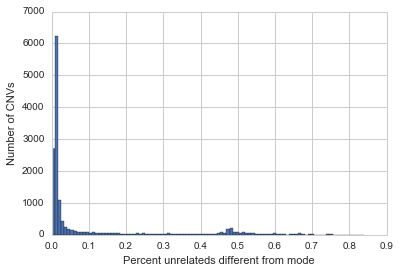

In [ ]:
cnv_info.unrelated_percent_diff_from_mode.hist(bins=100)
plt.ylabel('Number of CNVs')
plt.xlabel('Percent unrelateds different from mode');

In [ ]:
cnv_info.sort_values(by='unrelated_diff_from_mode', inplace=True)

In [ ]:
rare_cnv_info = cnv_info[cnv_info.unrelated_diff_from_mode == 1]
rare_cnv_info = rare_cnv_info.dropna(subset=['gene_overlaps'])

In [ ]:
lessr = []
for i in rare_cnv_info.index:
    se = cnv_geno.ix[i, unrelateds]
    mode = rare_cnv_info.ix[i, 'cn_mode']
    if sum(se < mode) > 0:
        lessr.append(se[se < mode])
rare_cnv_less = pd.DataFrame(lessr)
rare_cnv_less.to_csv(os.path.join(private_outdir, 'rare_cnv_less.tsv'), sep='\t')

In [ ]:
cnv_rare = []
cnv_rare_ase_pval = []
cnv_rare_less = []
cnv_rare_greater = []
cnv_not_rare = []
cnv_not_rare_ase_pval = []
for i in rare_cnv_info.index:
    se = cnv_geno.ix[i, unrelateds]
    mode = rare_cnv_info.ix[i, 'cn_mode']
    r = se[se != mode].index
    lessr = se[se < mode]
    greaterr = se[se > mode]
    nr = se[se == mode].index
    for g in set(rare_cnv_info.ix[i, 'gene_overlaps'].split(',')) & set(log_tpm_z.index):
        cnv_rare += list(log_tpm_z.ix[g, r])
        cnv_rare_less += list(log_tpm_z.ix[g, lessr])
        cnv_rare_greater += list(log_tpm_z.ix[g, greaterr])
        cnv_not_rare += list(log_tpm_z.ix[g, nr])
        if g in ase_pval.index:
            cnv_rare_ase_pval += list(ase_pval_f.ix[g, r])
            cnv_not_rare_ase_pval += list(ase_pval_f.ix[g, nr])
cnv_rare = pd.Series(cnv_rare)
cnv_rare_ase_pval = pd.Series(cnv_rare_ase_pval).dropna()
cnv_not_rare = pd.Series(cnv_not_rare)
cnv_rare_less = pd.Series(cnv_rare_less)
cnv_rare_greater = pd.Series(cnv_rare_greater)
cnv_not_rare_ase_pval = pd.Series(cnv_not_rare_ase_pval).dropna()

In [ ]:
r = sum(cnv_rare_ase_pval < 0.005) / float(cnv_rare_ase_pval.shape[0])
nr = sum(cnv_not_rare_ase_pval < 0.005) / float(cnv_not_rare_ase_pval.shape[0])
a = (cnv_rare_ase_pval < 0.005).value_counts()
b = (cnv_not_rare_ase_pval < 0.005).value_counts()
odds, p = stats.fisher_exact([[a[True], a[False]], [b[True], b[False]]])
print('Gene/samples with rare genic CNV have ASE {:.2f}% of the '
      'time while gene/samples without rare promoter DHS variant have ASE '
      '{:.2f}% of the time (odds={:.2f}, p={:.2e}, Fisher exact).'.format(r * 100, nr * 100, odds, p))

Gene/samples with rare genic CNV have ASE 8.04% of the time while gene/samples without rare promoter DHS variant have ASE 3.12% of the time (odds=2.72, p=9.73e-13, Fisher exact).


In [ ]:
s,p = stats.mannwhitneyu(cnv_rare, cnv_not_rare)
print('The distributions of z-score expression values for genes with and without '
      'rare genic CNVs is significantly different (Mann-Whitney U, p={:.2e}).'.format(p))

The distributions of z-score expression values for genes with and without rare genic CNVs is significantly different (Mann-Whitney U, p=8.41e-08).


In [ ]:
s,p = stats.mannwhitneyu(cnv_rare.abs(), cnv_not_rare.abs())
print('The distributions of z-score expression magnitudes for genes with and without '
      'rare genic CNVs is significantly different (Mann-Whitney U, p={:.2e}).'.format(p))

The distributions of z-score expression magnitudes for genes with and without rare genic CNVs is significantly different (Mann-Whitney U, p=1.56e-18).


In [ ]:
print(stats.mannwhitneyu(cnv_rare_less, cnv_not_rare))
print(stats.mannwhitneyu(cnv_rare_less.abs(), cnv_not_rare.abs()))

MannwhitneyuResult(statistic=244274758.0, pvalue=0.26920546044906934)
MannwhitneyuResult(statistic=195411157.0, pvalue=8.539737391520741e-53)


In [ ]:
print(stats.mannwhitneyu(cnv_rare_greater, cnv_not_rare))
print(stats.mannwhitneyu(cnv_rare_greater.abs(), cnv_not_rare.abs()))

MannwhitneyuResult(statistic=48318389.0, pvalue=3.2154123707138734e-22)
MannwhitneyuResult(statistic=52732573.0, pvalue=9.762408868882238e-13)


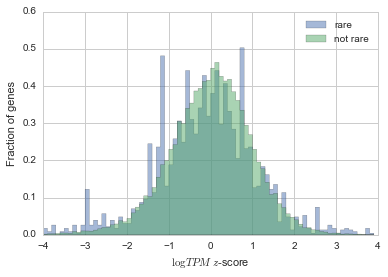

In [ ]:
cnv_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare')
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

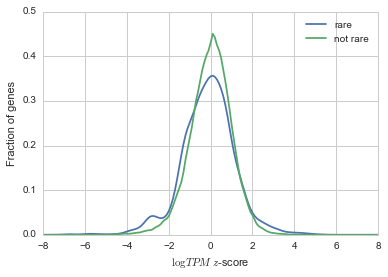

In [ ]:
xs = np.arange(-8, 8.1, 0.1)
density = scipy.stats.gaussian_kde(cnv_rare)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(cnv_not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

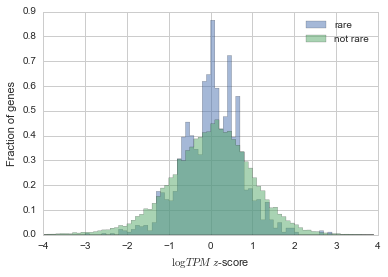

In [ ]:
cnv_rare_less.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare')
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

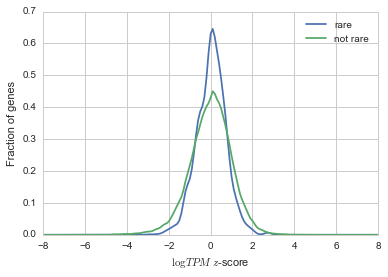

In [ ]:
xs = np.arange(-8, 8.1, 0.1)
density = scipy.stats.gaussian_kde(cnv_rare_less)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(cnv_not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

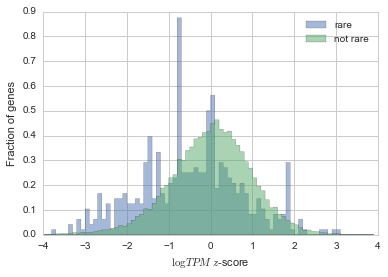

In [ ]:
cnv_rare_greater.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare')
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

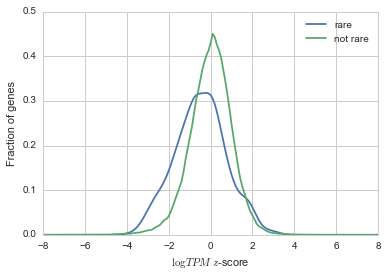

In [ ]:
xs = np.arange(-8, 8.1, 0.1)
density = scipy.stats.gaussian_kde(cnv_rare_greater)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(cnv_not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

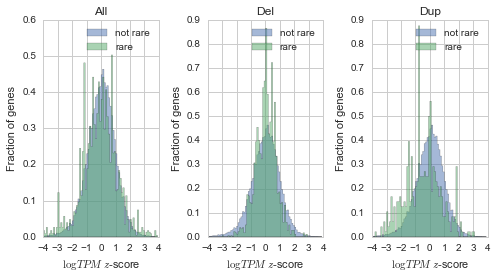

In [ ]:
fig,axs = plt.subplots(1, 3, figsize=(7, 4))
ax = axs[0]
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare', ax=ax)
cnv_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare', ax=ax)
ax.legend()
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score')
ax.set_title('All')

ax = axs[1]
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare', ax=ax)
cnv_rare_less.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare', ax=ax)
ax.legend()
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score');
ax.set_title('Del')

ax = axs[2]
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare', ax=ax)
cnv_rare_greater.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare', ax=ax)
ax.legend()
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score')
ax.set_title('Dup')

fig.tight_layout()
fig.savefig(os.path.join(outdir, 'rare_cnv_hists.pdf'))

In [ ]:
cnv_rare = []
cnv_rare_less = []
cnv_rare_greater = []
cnv_not_rare = []
for i in rare_cnv_info.index:
    se = cnv_geno.ix[i, unrelateds]
    mode = rare_cnv_info.ix[i, 'cn_mode']
    r = se[se != mode].index
    lessr = se[se < mode]
    greaterr = se[se > mode]
    nr = se[se == mode].index
    for g in set(rare_cnv_info.ix[i, 'gene_overlaps'].split(',')) & set(log_tpm_z.index):
        if greaterr.shape[0] > 0:
            if sum(log_tpm_z.ix[g, greaterr] < -2) > 0:
                print(i, g, greaterr)

('CNV_8_146276675_146279317', 'ENSG00000182307.8', f4b0146d-7508-457f-a754-bb4042583c4b    3
Name: CNV_8_146276675_146279317, dtype: int64)
('CNV_9_36273428_36278602', 'ENSG00000122705.12', 7e46a561-21f6-4340-b2e2-41ef50b7d943    3
Name: CNV_9_36273428_36278602, dtype: int64)
('CNV_7_148820780_148825437', 'ENSG00000197024.4', d5034b1e-43c1-486a-8d18-18b15f635e70    3
Name: CNV_7_148820780_148825437, dtype: int64)
('CNV_7_133582402_133604451', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133582402_133604451, dtype: int64)
('CNV_7_133552783_133574111', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133552783_133574111, dtype: int64)
('CNV_7_133526828_133552782', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133526828_133552782, dtype: int64)
('CNV_7_133472945_133511987', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133472945_133511987, dtype: int64)
('CNV_7_133425056_1

In [ ]:
gene_info.ix['ENSG00000122705.12']

gene_name                CLTA
gene_type      protein_coding
chrom                    chr9
start                36190852
end                  36304778
strand                      +
gene_status             KNOWN
source                 HAVANA
level                       1
Name: ENSG00000122705.12, dtype: object

In [ ]:
cnv_rare_greater.head()

AttributeError: 'list' object has no attribute 'head'

In [ ]:
tt = log_tpm_z.apply(lambda x: stats.mstats.normaltest(x)[1], axis=1)

In [ ]:
tt.hist()

In [ ]:
?fisher_exact